In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [3]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [5]:
files = glob('Cappello/Spinel_Barite/roi*.dat')
cnb_hcs = MixPhase([barite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(16).raw_snip(m=64)
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(cnb_hcs,spectra)]

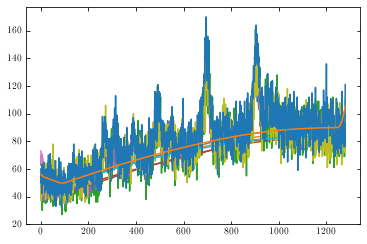

In [6]:
for s in xrd_spectra:
    plot(s.raw_intensity)
    plot(s.raw_snip)

In [ ]:
all_spinel = database['Spinel']
all_barite = database['Barite']
sb = []
for spinel in all_spinel:
    for barite in all_barite:
        sb += [MixPhase([spinel,barite])]
print('N mixtures:',len(sb))

x = arange(1280)
gn = []
for phase in sb:
    gn += [GaussNewton(phase,xrd_spectra[0])]
    
for g in gn[:]:
    for _ in range(64):
        g.calibration(alpha=1)
        g.opt = g.spectra.opt.copy()
    print(g.spectra.opt)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

In [ ]:
%matplotlib inline
fig,ax = subplots(8,1,figsize = (15,48))

for i,g in enumerate(gn[-8:]):
    
    g.spectra.opt = g.opt.copy()
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[ 0.01711791 -0.08676908  0.21962463  0.76499479  0.25888133  0.40852157
  0.66184064  0.3354319   1.0637543   1.08794177  0.31683976  2.76054663
  0.15527559  1.57341982  0.98495313  0.4232811   1.52680332  1.
 -3.45293727  5.21425884  2.23950703  0.96847235  0.28780404 -0.45048183
  0.93238277]


(19.0, 53.0)

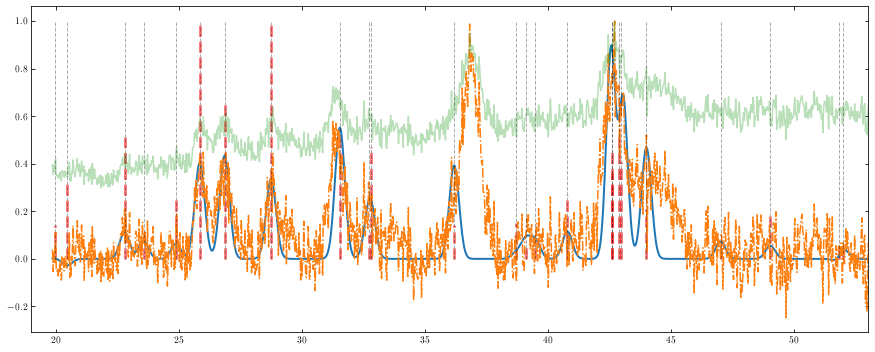

In [7]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(32):
    g.calibration(alpha=1)  
print(g.gamma)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
plot(s.theta,s.raw_intensity/s.raw_intensity.max(),'-',alpha=0.33)
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

xlim(19,53)
#ylim(0,1)

[-1230.05709468    52.25398202  1941.74838724]
[-1118.76236383    48.67002051  2018.71835904]
[-1168.03782883    50.33197005  1974.81605581]
[-1471.07155731    60.6593774   1732.37273106]
[-1231.01472756    52.07601969  1952.72344063]
[-1677.5314437     74.73654445  1232.99836703]


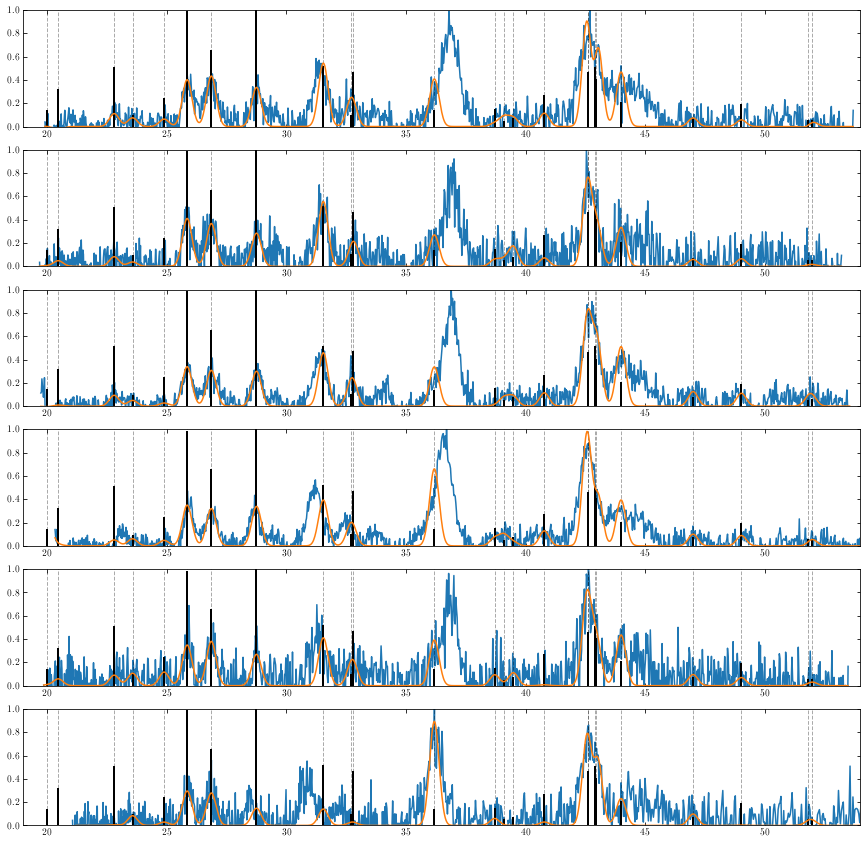

In [14]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=0.5)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.05)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1229.06339958    52.22288722  1942.38229127] [-1214.71937795    51.66346478  1952.71389334]
[-1118.7647794     48.67009162  2018.71712923] [-1214.71937795    51.66346478  1952.71389334]
[-1169.56658732    50.37813981  1973.97227706] [-1214.71937795    51.66346478  1952.71389334]
[-1285.48802566    53.91993717  1906.93470344] [-1214.71937795    51.66346478  1952.71389334]
[-1229.8117731     52.03788425  1953.55059946] [-1214.71937795    51.66346478  1952.71389334]
[-1607.56103991    67.35380226  1516.51316481] [-1214.71937795    51.66346478  1952.71389334]


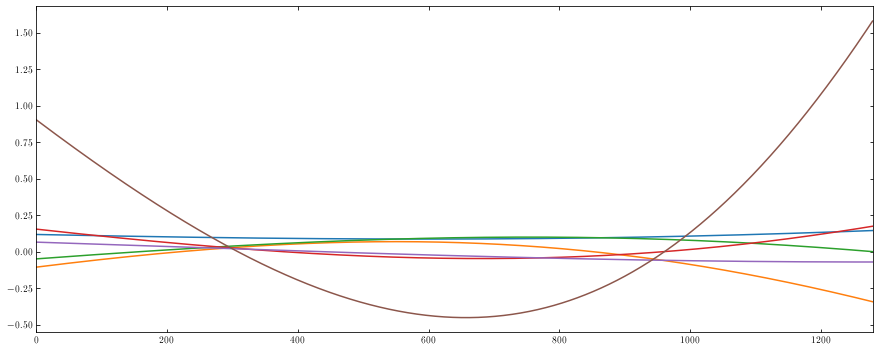

In [12]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
